In [3]:
!pip install lenstronomy

     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
     ----------------------- ---------------- 1.0/1.8 MB 6.3 MB/s eta 0:00:01
     ---------------------------- ----------- 1.3/1.8 MB 3.7 MB/s eta 0:00:01
     ---------------------------------- ----- 1.6/1.8 MB 2.8 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 2.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 3.4 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.7 MB 3.5 MB/s eta 0:0

  You can safely remove it manually.
  You can safely remove it manually.


In [30]:
from astropy.constants import c, G
import numpy as np
from scipy.optimize import brentq
from astropy.cosmology import FlatLambdaCDM



class sie_lens(object):
# """class SIE"""
    def __init__(self,co, zl=0.3,zs=2.0,sigmav=200,f=0.6,pa=45.0):
#     """
#     Initialize the SIE object.
#     Dimensionless units are used. The scale angle is given by the
#     SIS Einstein radius.
# """
        self.sigmav=sigmav # velocity dispersion
        self.co=co # cosmological model
        self.zl=zl # lens redshift
        self.zs=zs # source redshift
        self.f=f # axis ratio
        self.pa=pa*np.pi/180.0 # position angle
        # compute the angular diameter distances:
        self.dl=self.co.angular_diameter_distance(self.zl)
        self.ds=self.co.angular_diameter_distance(self.zs)
        self.dls=self.co.angular_diameter_distance_z1z2(self.zl,self.zs)
        # calculates the Einstein radius of the SIS lens
        # in arcsec
        self.theta0=np.rad2deg((4.0*np.pi*sigmav**2/(c.to("km/s"))**2*
        self.dls/self.ds).value)*3600.0
    def delta(self,f,phi):
        return np.sqrt(np.cos(phi-self.pa)**2 + self.f**2*np.sin(phi-self.pa)**2)
    
    def kappa(self,x,phi):
#     """
# Convergence for the SIE lens at position (x,phi) in polar
# coordinates.
# """
        return(np.sqrt(self.f)/2.0/x/self.delta(self.f,phi))
    
    def gamma(self,x,phi):
# """
# Shear for the SIE lens at position (x,phi) in polar coordinates.
# """
        return(-self.kappa(x,phi)*np.cos(2.0*phi-self.pa),-self.kappa(x,phi)*np.sin(2.0*phi-self.pa))
    def mu(self,x,phi):
# """
# Magnification for the SIE lens at position (x,phi) in polar
# coordinates.
# """
        ga1,ga2=self.gamma(x,phi)
        ga=np.sqrt(ga1*ga1+ga2*ga2)
        return 1.0/(1.0-self.kappa(x,phi)-ga)/(1.0-self.kappa(x,phi)+ga)
    def psi_tilde(self,phi):
# """
# angular part of the lensing potential at the polar angle phi
# """
        if (self.f < 1.0):
            fp=np.sqrt(1.0-self.f**2)
            return np.sqrt(self.f)/fp*\
            (np.sin(phi-self.pa)*np.arcsin(fp*np.sin(phi-self.pa))+
            np.cos(phi-self.pa)*np.arcsinh(fp/f
            *np.cos(phi-self.pa)))
        else:
            return(1.0)
        
    def psi(self,x,phi):
# """
# Lensing potential at polar coordinates x,phi
# """
        psi=x*self.psi_tilde(phi)
        return psi
    
    def alpha(self,phi):
# """
# Deflection angle as a function of the polar angle phi
# """
        fp=np.sqrt(1.0-self.f**2)
        a1=np.sqrt(self.f)/fp*np.arcsinh(fp/self.f*np.cos(phi))
        a2=np.sqrt(self.f)/fp*np.arcsin(fp*np.sin(phi))
        return a1,a2



    def cut(self,phi_min=0,phi_max=2.0*np.pi,nphi=1000):
# """
# Coordinates of the points on the cut.
# The arguments phi_min, phi_max, nphi define the range of
# polar angles used.
# """
        phi=np.linspace(phi_min,phi_max,nphi)
        y1_,y2_=self.alpha(phi)
        y1 = y1_ * np.cos(self.pa)- y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return-y1,-y2
    

    def tan_caustic(self,phi_min=0,phi_max=2.0*np.pi,nphi=1000):
# """
# Coordinates of the points on the tangential caustic.
# The arguments phi_min, phi_max, nphi define the range of
# polar angles used.
# """
        phi=np.linspace(phi_min,phi_max,nphi)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        a1,a2=self.alpha(phi)
        y1_=np.sqrt(self.f)/delta*np.cos(phi)-a1
        y2_=np.sqrt(self.f)/delta*np.sin(phi)-a2
        y1 = y1_ * np.cos(self.pa)- y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return y1,y2
    
    def tan_cc(self,phi_min=0,phi_max=2.0*np.pi,nphi=1000):
# """
# Coordinates of the points on the tangential critical line.
# The arguments phi_min, phi_max, nphi define the range of
# polar angles used.
# """
        phi=np.linspace(phi_min,phi_max,nphi)
        delta=np.sqrt(np.cos(phi)**2+self.f**2*np.sin(phi)**2)
        r=np.sqrt(self.f)/delta
        x1=r*np.cos(phi+self.pa)
        x2=r*np.sin(phi+self.pa)
        return(x1,x2)
    
    def x_ima(self,y1,y2,phi):
# """
# Distance of the image from the lens center
# """
        x=y1*np.cos(phi)+y2*np.sin(phi)+(self.psi_tilde(phi+self.pa))
        return x
    
    def phi_ima(self,y1,y2,checkplot=True,eps=0.001,nphi=100):
    # """
    # Solve the lens Equation for a given source position (y1,y2)
    # """
    # source position in the frame where the lens major axis is
    # along the £x_2£ axis.
        y1_ = y1 * np.cos(self.pa) + y2 * np.sin(self.pa)
        y2_ =-y1 * np.sin(self.pa) + y2 * np.cos(self.pa)
    # This is Eq.\,\ref{eq:ffunct}
        def phi_func(phi):
            a1,a2=self.alpha(phi)
            func=(y1_+a1)*np.sin(phi)-(y2_+a2)*np.cos(phi)
            return func
    # Evaluate phi_func and the sign of phi_func on an array of
    # polar angles
        U=np.linspace(0.,2.0*np.pi+eps,nphi)
        c = phi_func(U)
        s = np.sign(c)
        phi=[]
        xphi=[]
    # loop over polar angles


# loop over polar angles
        for i in range(len(U)-1):
 # if two polar angles bracket a zero of phi_func,
 # use Brent’s method to find exact solution
            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(phi_func, U[i], U[i+1])
                z = phi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x=self.x_ima(y1_,y2_,u)
 # append solution to a list if it corresponds to radial
 # distances x>0; discard otherwise (spurious solutions)
                if (x>0):
                    phi.append(u)
                    xphi.append(x)
 # convert lists to numpy arrays
        xphi=np.array(xphi)
        phi=np.array(phi)
 # returns radii and polar angles of the images. Add position angle
 # to go back to the rotated frame of the lens.
        return xphi,phi+self.pa



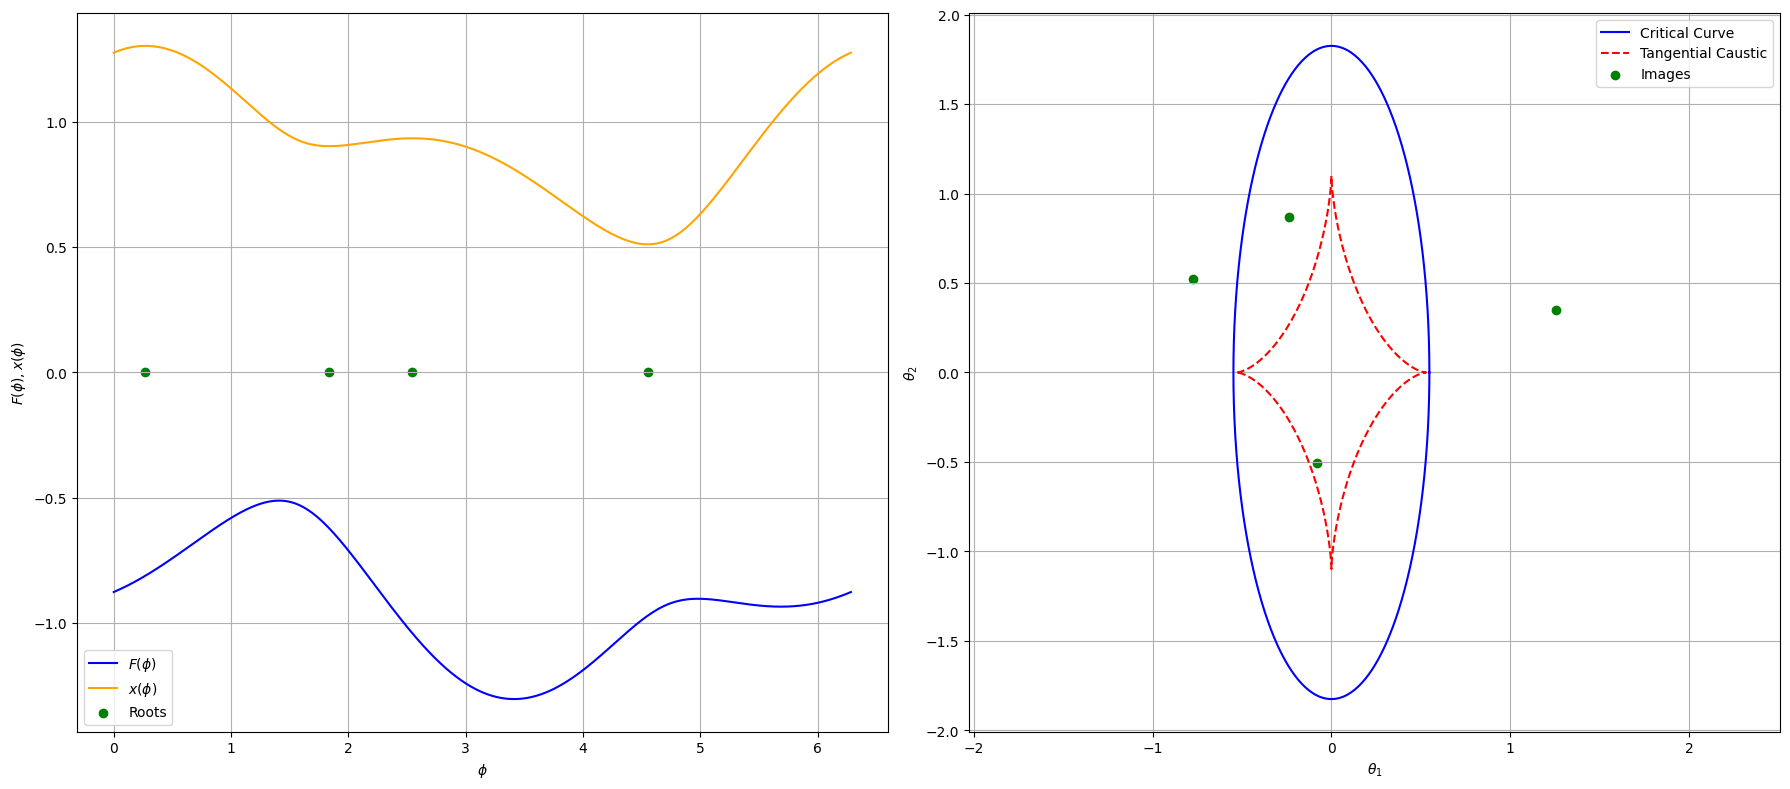

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.constants import c, G
from astropy.cosmology import FlatLambdaCDM

# Define the sie_lens class as provided earlier with updated methods for numpy compatibility
class sie_lens:
    def __init__(self, co, zl=0.3, zs=2.0, sigmav=200, f=0.6, pa=45.0):
        self.sigmav = sigmav  # velocity dispersion
        self.co = co  # cosmological model
        self.zl = zl  # lens redshift
        self.zs = zs  # source redshift
        self.f = f  # axis ratio
        self.pa = pa * np.pi / 180.0  # position angle
        self.dl = self.co.angular_diameter_distance(self.zl)
        self.ds = self.co.angular_diameter_distance(self.zs)
        self.dls = self.co.angular_diameter_distance_z1z2(self.zl, self.zs)
        self.theta0 = np.rad2deg((4.0 * np.pi * sigmav**2 / (c.to("km/s"))**2 * self.dls / self.ds).value) * 3600.0

    def delta(self, phi):
        return np.sqrt(np.cos(phi - self.pa)**2 + self.f**2 * np.sin(phi - self.pa)**2)

    def alpha(self, phi):
        fp = np.sqrt(1.0 - self.f**2)
        a1 = np.sqrt(self.f) / fp * np.arcsinh(fp / self.f * np.cos(phi))
        a2 = np.sqrt(self.f) / fp * np.arcsin(fp * np.sin(phi))
        return a1, a2

    def psi_tilde(self, phi):
        if self.f < 1.0:
            fp = np.sqrt(1.0 - self.f**2)
            return np.sqrt(self.f) / fp * (
                np.sin(phi - self.pa) * np.arcsin(fp * np.sin(phi - self.pa))
                + np.cos(phi - self.pa) * np.arcsinh(fp / self.f * np.cos(phi - self.pa))
            )
        else:
            return np.ones_like(phi)

    def cut(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        phi = np.linspace(phi_min, phi_max, nphi)
        y1_, y2_ = self.alpha(phi)
        y1 = y1_ * np.cos(self.pa) - y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return -y1, -y2

    def tan_caustic(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        phi = np.linspace(phi_min, phi_max, nphi)
        delta = np.sqrt(np.cos(phi)**2 + self.f**2 * np.sin(phi)**2)
        a1, a2 = self.alpha(phi)
        y1_ = np.sqrt(self.f) / delta * np.cos(phi) - a1
        y2_ = np.sqrt(self.f) / delta * np.sin(phi) - a2
        y1 = y1_ * np.cos(self.pa) - y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return y1, y2

    def tan_cc(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        phi = np.linspace(phi_min, phi_max, nphi)
        delta = np.sqrt(np.cos(phi)**2 + self.f**2 * np.sin(phi)**2)
        r = np.sqrt(self.f) / delta
        x1 = r * np.cos(phi + self.pa)
        x2 = r * np.sin(phi + self.pa)
        return x1, x2

    def x_ima(self, y1, y2, phi):
        return y1 * np.cos(phi) + y2 * np.sin(phi) + self.psi_tilde(phi + self.pa)

    def phi_ima(self, y1, y2, eps=0.001, nphi=1000):
        y1_ = y1 * np.cos(self.pa) + y2 * np.sin(self.pa)
        y2_ = -y1 * np.sin(self.pa) + y2 * np.cos(self.pa)

        def phi_func(phi):
            a1, a2 = self.alpha(phi)
            return (y1_ + a1) * np.sin(phi) - (y2_ + a2) * np.cos(phi)

        U = np.linspace(0, 2.0 * np.pi + eps, nphi)
        c = phi_func(U)
        s = np.sign(c)
        phi = []
        xphi = []

        for i in range(len(U) - 1):
            if s[i] + s[i + 1] == 0:  # opposite signs
                u = brentq(phi_func, U[i], U[i + 1])
                z = phi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x = self.x_ima(y1_, y2_, u)
                if x > 0:
                    phi.append(u)
                    xphi.append(x)

        return np.array(xphi), np.array(phi) + self.pa


# Define the lens parameters
sigmav = 200.0
f = 0.3
pa = 0.0
co = FlatLambdaCDM(Om0=0.3, H0=70.0)
sie = sie_lens(co, sigmav=sigmav, f=f, pa=pa)

# Source coordinates
y1, y2 = 0.2, 0.2

# Polar coordinates of the images
x, phi = sie.phi_ima(y1, y2)
x1_ima = x * np.cos(phi)
x2_ima = x * np.sin(phi)

# Compute cut, caustic, and critical line
y1_cut, y2_cut = sie.cut()
y1_cau, y2_cau = sie.tan_caustic()
x1_cc, x2_cc = sie.tan_cc()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Left Panel: F(phi) and x(phi)
phi_values = np.linspace(0, 2 * np.pi, 1000)
F_phi = (y1 * np.cos(phi_values) + y2 * np.sin(phi_values)) - sie.psi_tilde(phi_values + sie.pa)
x_phi = sie.x_ima(y1, y2, phi_values)

ax[0].plot(phi_values, F_phi, label=r"$F(\phi)$", color="blue")
ax[0].plot(phi_values, x_phi, label=r"$x(\phi)$", color="orange")
ax[0].scatter(phi, np.zeros_like(phi), color="green", label="Roots")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$F(\phi), x(\phi)$")
ax[0].legend()
ax[0].grid()

# Right Panel: Critical Curve and Caustic
ax[1].plot(x1_cc, x2_cc, label="Critical Curve", color="blue")
ax[1].plot(y1_cau, y2_cau, label="Tangential Caustic", linestyle="--", color="red")
ax[1].scatter(x1_ima, x2_ima, color="green", label="Images")
ax[1].set_xlabel(r"$\theta_1$")
ax[1].set_ylabel(r"$\theta_2$")
ax[1].axis("equal")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

In [39]:
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# observation parameters:
background_rms = 0.5 # background noise per pixel
exp_time = 100 # exposure time (arbitrary units)
numPix = 100 # number of pixels
deltaPix = 0.05 # pixel size in arcsec
# PSF specification
fwhm = 0.1 # PSF FWHM
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix,
                                            exp_time,
                                            background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {"psf_type": "GAUSSIAN",
            "fwhm": fwhm,
            "pixel_size": deltaPix,
            "truncation": 5}
psf_class = PSF(**kwargs_psf)

In [41]:
# lens parameters
f=0.7
sigmav=200.
pa=np.pi/4.0 # position angle in radians
zl=0.3 # lens redshift
zs=1.5 # source redshift
# lens Einstein radius
from astropy.cosmology import FlatLambdaCDM
co = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.constants import c, G
dl=co.angular_diameter_distance(zl)
ds=co.angular_diameter_distance(zs)
dls=co.angular_diameter_distance_z1z2(zl,zs)
# compute the Einstein radius
thetaE=1e6*(4.0*np.pi*sigmav**2/c**2*dls/ds*180.0/np.pi*3600.0).value
# eccentricity computation
e1,e2=(1-f)/(1+f)*np.cos(-2*pa),(1-f)/(1+f)*np.sin(-2*pa)
lens_model_list = ["SIE"]
kwargs_sie = {"theta_E": thetaE,
            "center_x": 0,
            "center_y": 0,
            "e1": e1,
            "e2": e2}
kwargs_lens = [kwargs_sie]
lens_model_class = LensModel(lens_model_list=lens_model_list)

In [42]:
# create the light model for the lens (SERSIC_ELLIPSE)
lens_light_model_list = ["SERSIC_ELLIPSE"]
kwargs_sersic = {"amp": 3500, # flux of the lens (arbitrary units)
                "R_sersic": 2., # effective radius
                "n_sersic": 4, # sersic index
                "center_x": 0, # x-coordinate
                "center_y": 0, # y-coordinate
                "e1": e1,
                "e2": e2}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
# create the light model for the source (SERSIC_ELLIPSE)
source_model_list = ["SERSIC_ELLIPSE"]
# set the position of the source
ra_source, dec_source =-0.1*thetaE, thetaE
kwargs_sersic_ellipse = {"amp": 4000.,
                        "R_sersic": .1,
                        "n_sersic": 3,
                        "center_x": ra_source,
                        "center_y": dec_source,
                        "e1": 0.1,
                        "e2": 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)
# solve the lens equation and find the image positions
# using the LensEquationSolver class of Lenstronomy.
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source,
                                                                dec_source,
                                                                kwargs_lens,
                                                                min_distance=deltaPix,
                                                                search_window=numPix * deltaPix,
                                                                precision_limit=1e-10, num_iter_max=100,
                                                                arrival_time_sort=True,
                                                                initial_guess_cut=True,
                                                                verbose=False,
                                                                x_center=0,
                                                                y_center=0,
                                                                num_random=0,
                                                                non_linear=False,
                                                                magnification_limit=None)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag) # ignore the sign of the magnification
# perturb observed magnification due to e.g. micro-lensing
# the noise is generated from a normal distribution
# with mean "mag" and standard deviation 0.5
mag_pert = np.random.normal(mag, 0.5, len(mag))
# point_amp = mag_pert
point_amp = [3500, 4000]  # İki görüntü için sabit amplitüdler
# quasar position in the lens plane
kwargs_ps = [{"ra_image": x_image,
            "dec_image": y_image,
            "point_amp": point_amp}]
point_source_list = ["LENSED_POSITION"]
point_source_class = PointSource(point_source_type_list=point_source_list,
                                fixed_magnification_list=[False])
# create the simulated observation of lens and (lensed)
# source
kwargs_numerics = {"supersampling_factor": 1,
                    "supersampling_convolution": False}
# imageModel includes the details of the instrument, psf, lens,
# and source models
imageModel = ImageModel(data_class, psf_class, lens_model_class,
                        source_model_class,lens_light_model_class,point_source_class,
                        kwargs_numerics=kwargs_numerics)
# now, the simulated image is saved in image_sim
image_sim = imageModel.image(kwargs_lens, kwargs_source,
                            kwargs_lens_light, kwargs_ps)
# add noise and background
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson 



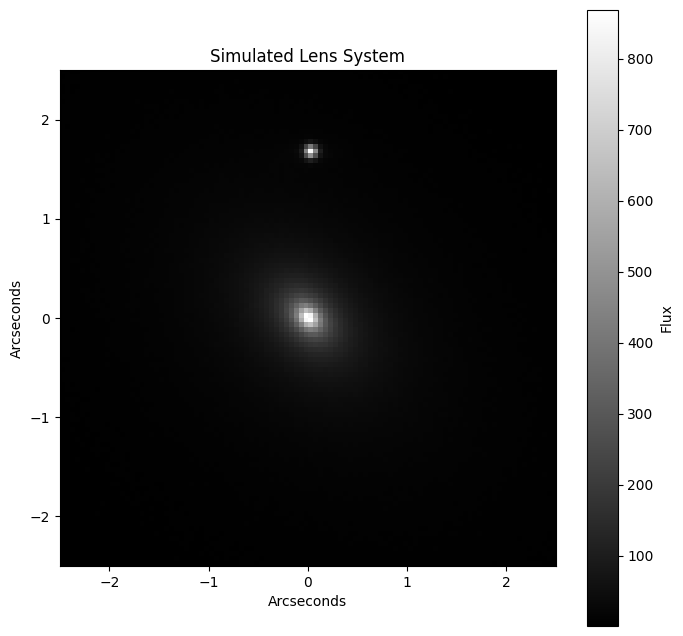

In [10]:
import matplotlib.pyplot as plt

# Plot the simulated image
plt.figure(figsize=(8, 8))
plt.imshow(image_sim, origin='lower', cmap='gray', extent=[-numPix/2 * deltaPix, numPix/2 * deltaPix, -numPix/2 * deltaPix, numPix/2 * deltaPix])
plt.colorbar(label="Flux")
plt.title("Simulated Lens System")
plt.xlabel("Arcseconds")
plt.ylabel("Arcseconds")
plt.show()


Lens Modeling

In [43]:
mu, sigma = 0, 0.015 # mean and standard deviation
s1 = np.random.normal(mu, sigma, len(x_image))
s2 = np.random.normal(mu, sigma, len(y_image))
x1_ima=x_image+s1
x2_ima=y_image+s2

In [49]:
# function that calculates the source positions of an ensemble
# of point images
def guess_source(sie_m,x1_ima,x2_ima):
# calculate the deflection angle at the image positions
    phi=np.arctan2(x2_ima,x1_ima)
    a1_ima_,a2_ima_=sie_m.alpha(phi-sie_m.pa)
# apply rotation by the lens position angle
    a1_ima=a1_ima_*np.cos(sie_m.pa)-a2_ima_*np.sin(sie_m.pa)
    a2_ima=a1_ima_*np.sin(sie_m.pa)+a2_ima_*np.cos(sie_m.pa)
    # use lens equation to find source positions
    y1_ima=x1_ima-a1_ima
    y2_ima=x2_ima-a2_ima
    return y1_ima, y2_ima
# first guess for the lens model: assuming sigmav=180 km/s,
# f=0.3, and pa=40 degrees
sie_m=sie_lens(co,sigmav=180.0,zl=0.3,zs=2.0,f=0.3,pa=40.0)
# calculate the source positions using the model
y1_ima,y2_ima = guess_source(sie_m,
                            x1_ima/sie_m.theta0,
                            x2_ima/sie_m.theta0)


# x_m,phi_m=sie_m.phi_ima(y1_m,y2_m,checkplot=False,verbose=False)
# x1_ima_m=x_m*np.cos(phi_m)
# x2_ima_m=x_m*np.sin(phi_m)



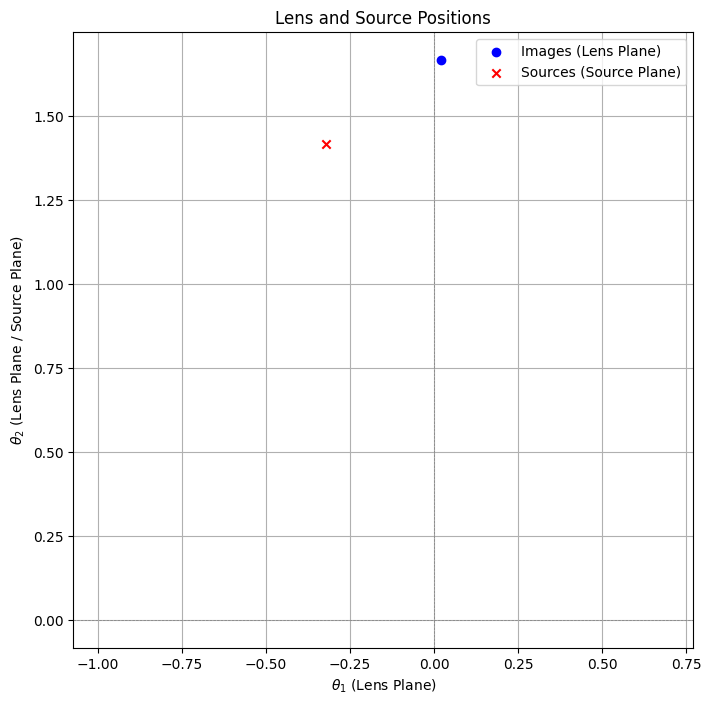

In [50]:
# Görselleştirme: Kaynak ve görüntü pozisyonlarını çizelim

plt.figure(figsize=(8, 8))

# Görüntü pozisyonlarını çiz
plt.scatter(x1_ima, x2_ima, color="blue", label="Images (Lens Plane)")

# Tahmini kaynak pozisyonlarını çiz
plt.scatter(y1_ima, y2_ima, color="red", label="Sources (Source Plane)", marker="x")

# Eksenleri düzenle
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.5)
plt.xlabel(r"$\theta_1$ (Lens Plane)")
plt.ylabel(r"$\theta_2$ (Lens Plane / Source Plane)")
plt.title("Lens and Source Positions")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()


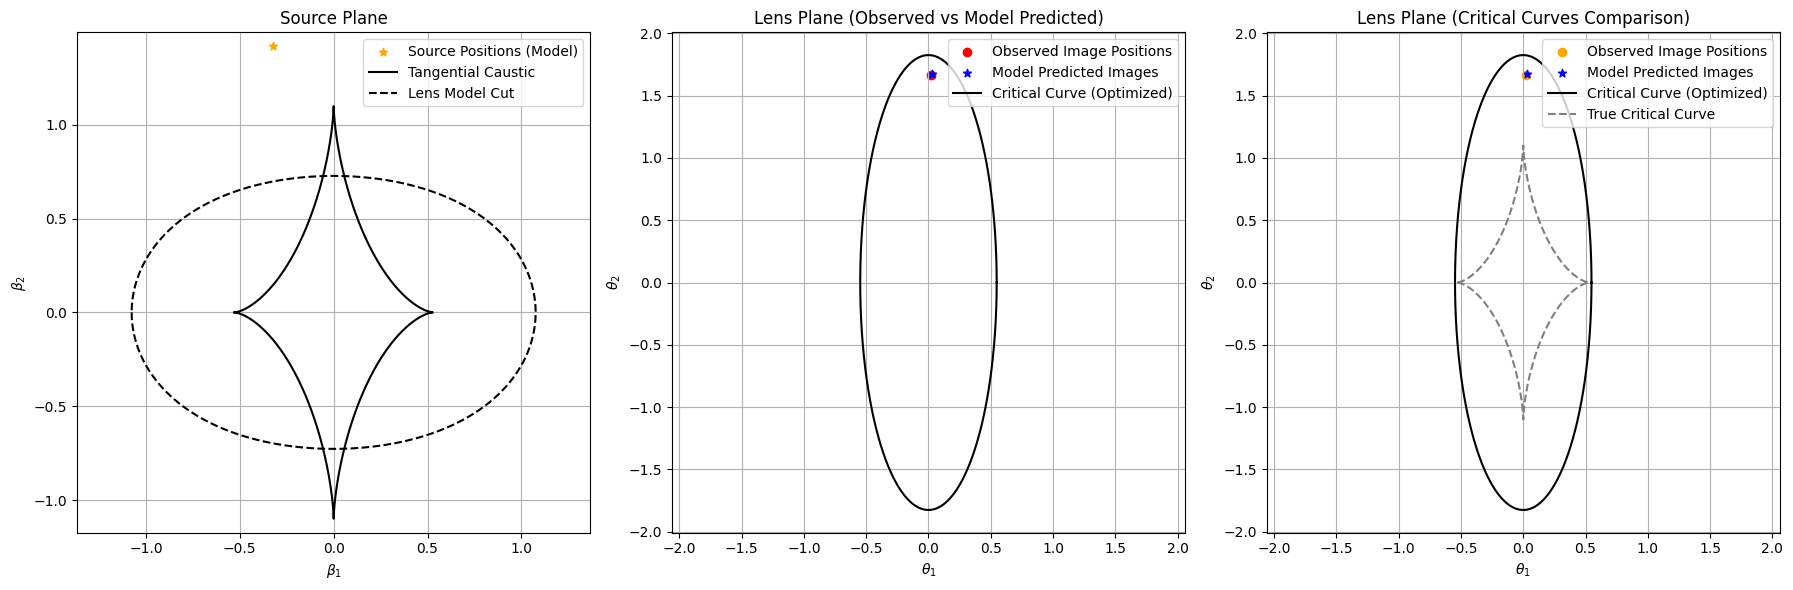

In [47]:
# Gerekli görselleri oluşturmak için kaynak ve lens düzlemindeki pozisyonları çizelim

# Önce kaynak düzlemi (Left Panel)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sol panel: Kaynak düzlemi
axes[0].scatter(y1_ima, y2_ima, color="orange", label="Source Positions (Model)", marker="*")
axes[0].plot(y1_cau, y2_cau, color="black", linestyle="solid", label="Tangential Caustic")
axes[0].plot(y1_cut, y2_cut, color="black", linestyle="dashed", label="Lens Model Cut")
axes[0].set_title("Source Plane")
axes[0].set_xlabel(r"$\beta_1$")
axes[0].set_ylabel(r"$\beta_2$")
axes[0].legend()
axes[0].axis("equal")
axes[0].grid()

# Orta panel: Lens düzlemi (gözlemlenen ve model tahmini görüntüler)
axes[1].scatter(x1_ima, x2_ima, color="red", label="Observed Image Positions", marker="o")
axes[1].scatter(x_image, y_image, color="blue", label="Model Predicted Images", marker="*")
axes[1].plot(x1_cc, x2_cc, color="black", linestyle="solid", label="Critical Curve (Optimized)")
axes[1].set_title("Lens Plane (Observed vs Model Predicted)")
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()
axes[1].axis("equal")
axes[1].grid()

# Sağ panel: Lens düzlemi (kritik eğriler karşılaştırması)
axes[2].scatter(x1_ima, x2_ima, color="orange", label="Observed Image Positions", marker="o")
axes[2].scatter(x_image, y_image, color="blue", label="Model Predicted Images", marker="*")
axes[2].plot(x1_cc, x2_cc, color="black", linestyle="solid", label="Critical Curve (Optimized)")
axes[2].plot(y1_cau, y2_cau, color="gray", linestyle="dashed", label="True Critical Curve")
axes[2].set_title("Lens Plane (Critical Curves Comparison)")
axes[2].set_xlabel(r"$\theta_1$")
axes[2].set_ylabel(r"$\theta_2$")
axes[2].legend()
axes[2].axis("equal")
axes[2].grid()

plt.tight_layout()
plt.show()


In [15]:
# function that calculates the source positions of an ensemble
# of point images
def guess_source(sie_m,x1_ima,x2_ima):
    # calculate the deflection angle at the image positions
    phi=np.arctan2(x2_ima,x1_ima)
    a1_ima_,a2_ima_=sie_m.alpha(phi-sie_m.pa)
    # apply rotation by the lens position angle
    a1_ima=a1_ima_*np.cos(sie_m.pa)-a2_ima_*np.sin(sie_m.pa)
    a2_ima=a1_ima_*np.sin(sie_m.pa)+a2_ima_*np.cos(sie_m.pa)
    # use lens equation to find source positions
    y1_ima=x1_ima-a1_ima
    y2_ima=x2_ima-a2_ima
    return y1_ima, y2_ima
# first guess for the lens model: assuming sigmav=180 km/s,
# f=0.3, and pa=40 degrees
sie_m=sie_lens(co,sigmav=180.0,zl=0.3,zs=2.0,f=0.3,pa=40.0)
# calculate the source positions using the model
y1_ima,y2_ima = guess_source(sie_m,
                            x1_ima/sie_m.theta0,
                            x2_ima/sie_m.theta0)

NameError: name 'sie_lens' is not defined

In [ ]:
 x_m,phi_m=sie_m.phi_ima(y1_m,y2_m,checkplot=False,verbose=False)
 x1_ima_m=x_m*np.cos(phi_m)
 x2_ima_m=x_m*np.sin(phi_m)

In [ ]:
import lmfit
# parameter set for the initial guesses. For each parameter
# we indicate also the range of values where the solution will
# be searched (e.g. sigma_v is initially set to 130 km/s and
# the range is between 50 and 300 km/s)
p = lmfit.Parameters()
p.add_many((’sigmav’, 130., True, 50, 300),
(’f’, 0.8, True, 0.2, 1.0),
(’pa’, 45.0, True, 20., 60.))
# implementation of the cost function:
# returns the distances between observed and model predicted
# image positions.
def cost_function(p,x1_ima,x2_ima,sigma_ima):
sie_m=sie_lens(co,sigmav=p[’sigmav’],
zl=0.3,zs=2.0,
f=p[’f’],pa=p[’pa’])
y1_ima,y2_ima =
guess_source(sie_m,x1_ima/sie_m.theta0,x2_ima/sie_m.theta0)
y1_m=y1_ima.mean()
y2_m=y2_ima.mean()
x_m,phi_m=sie_m.phi_ima(y1_m,y2_m,checkplot=False,
verbose=False)
x1_ima_m=x_m*np.cos(phi_m)*sie_m.theta0
x2_ima_m=x_m*np.sin(phi_m)*sie_m.theta0
imod=[]
for i in range(len(x1_ima)):
    d=(x1_ima[i]-x1_ima_m)**2+(x2_ima[i]-x2_ima_m)**2
    imod.append(np.argmin(d))
    res1=(x1_ima_m[imod]-x1_ima)/sigma_ima
    res2=(x2_ima_m[imod]-x2_ima)/sigma_ima
return res1, res2
 # minimize the cost function (here using the ’powell’ method)
 mi = lmfit.minimize(cost_function, p,
 method=’powell’,
 args=(x1_ima,x2_ima,sigma_ima))